In [147]:
import numpy as np; import pandas as pd; 
import matplotlib.pyplot as plt; import xarray as xr;
import matplotlib.ticker as mticker
import os, sys, fsspec, importlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from datetime import datetime, timedelta

sys.path.append( '/home/noelgb/repositories/modview/modview')
import viztools

sys.path.append( '/home/noelgb/repositories/slab/')
import models
importlib.reload( models )

fs = fsspec.filesystem('local')



In [148]:
from datetime import datetime, timedelta

def refine_time( xr_obj, dt ):
    # Interpolate xr_obj onto a time vector
    # with predetermined dt (given in seconds)
    total_time = ( xr_obj['time'][-1] - xr_obj['time'][0] ).astype( \
                             'timedelta64[s]')/np.timedelta64(1,'s')
    nsteps = int( total_time / dt )
    new_time = [ pd.to_datetime( xr_obj['time'][0].values ) \
                  + timedelta( seconds = jj * dt ) for jj in range( nsteps ) ]
    return xr_obj.interp( time = new_time )

In [159]:
front_surf = xr.open_dataset( 'front_surf_sup.nc' ).rename({'valid_time':'time'})
front_surf = xr.open_dataset( 'mangkhut_surf_sup.nc' ).rename({'valid_time':'time'})
front_surf = refine_time( front_surf, 10 * 60 )
#front_surf = front_surf.isel( time = range( 20 ) )

/tmp/ipykernel_264545/4182182791.py:6: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  total_time = ( xr_obj['time'][-1] - xr_obj['time'][0] ).astype( \


In [161]:
front_surf['latitude']

<xarray.DataArray 'latitude' (latitude: 101)>
array([25.  , 24.75, 24.5 , 24.25, 24.  , 23.75, 23.5 , 23.25, 23.  , 22.75,
       22.5 , 22.25, 22.  , 21.75, 21.5 , 21.25, 21.  , 20.75, 20.5 , 20.25,
       20.  , 19.75, 19.5 , 19.25, 19.  , 18.75, 18.5 , 18.25, 18.  , 17.75,
       17.5 , 17.25, 17.  , 16.75, 16.5 , 16.25, 16.  , 15.75, 15.5 , 15.25,
       15.  , 14.75, 14.5 , 14.25, 14.  , 13.75, 13.5 , 13.25, 13.  , 12.75,
       12.5 , 12.25, 12.  , 11.75, 11.5 , 11.25, 11.  , 10.75, 10.5 , 10.25,
       10.  ,  9.75,  9.5 ,  9.25,  9.  ,  8.75,  8.5 ,  8.25,  8.  ,  7.75,
        7.5 ,  7.25,  7.  ,  6.75,  6.5 ,  6.25,  6.  ,  5.75,  5.5 ,  5.25,
        5.  ,  4.75,  4.5 ,  4.25,  4.  ,  3.75,  3.5 ,  3.25,  3.  ,  2.75,
        2.5 ,  2.25,  2.  ,  1.75,  1.5 ,  1.25,  1.  ,  0.75,  0.5 ,  0.25,
        0.  ])
Coordinates:
    number    int64 0
  * latitude  (latitude) float64 25.0 24.75 24.5 24.25 ... 0.75 0.5 0.25 0.0
Attributes:
    units:             degrees_north
    standard_name:     latitude
    long_name:         latitude
    stored_direction:  decreasing

In [150]:
#cake = models.wstress( front_surf )
#curl, div = models.vort_div( cake )
world = models.double_decker( front_surf )

In [162]:
solver = world.new_solution( 140, 15 , 45 )

In [163]:
z, s, h = solver.TH_first_order( 0 )

In [164]:
solver.run_through()

(-1.0, 1.0)

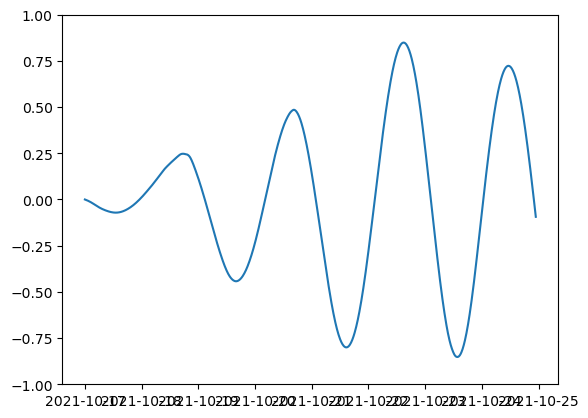

In [165]:
#sol1 = np.real( solver.th_sol['sigma'] ).copy()
#tim1 = solver.forcing['time'].copy()

plt.plot( solver.forcing['time'], np.real( solver.ml_sol['zeta'] ) )
#plt.ylim([-5e-7, 5e-7])
plt.ylim([-1,1])

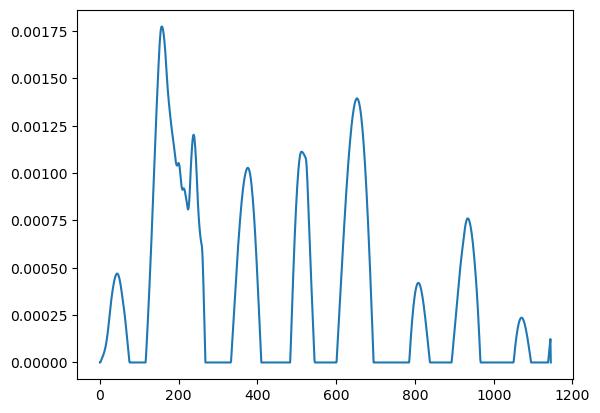

In [166]:
plt.plot( np.real( solver.r ) / solver.f )

In [156]:
solver.f

9.348966816711922e-05

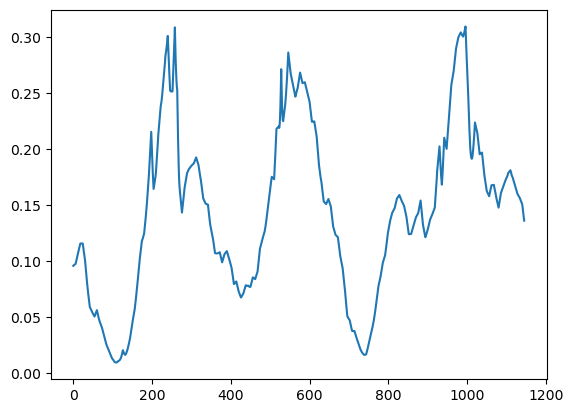

In [170]:
plt.plot( np.abs(solver.forcing['tau']) )

In [122]:
def energy_flux( solutions ):
    # Compute energy flux out of the mixed layer base
    w = solutions.ml_sol['h'] * np.imag( solutions.ml_sol['sigma'] )
    hprime = solutions.ml_sol['h'] - solutions.ml_sol['h'][0] 
    pprime = 9.81 * hprime * 1025
    return w * pprime

cake = energy_flux( solver )

In [106]:
cake = [ np.abs( solver.ML_second_order( jj )) for jj in range( len( solver.forcing['time'] ) ) ]

TypeError: ML_second_order() missing 1 required positional argument: 'tind'

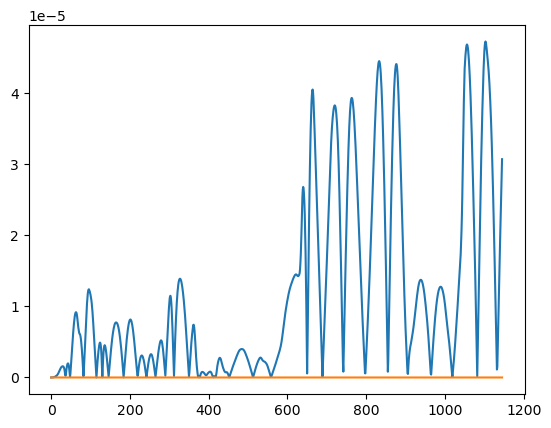

In [61]:
plt.plot( np.abs( cake ) )

In [ ]:
# Compute wind stress
def drag_coeff( wspeed ):
    Cd = 1.2e-3 * np.ones( wspeed.shape ); # ones
    faster = wspeed > 11; # meters per second
    Cd[faster] = ( 0.49 + 0.065 * wspeed.values[faster] ) * 1e-3
    fastest = wspeed > 25
    Cd[fastest] = 0.002;
    return Cd

def wstress( era_dat , surf = False):
    if surf:
        comp_vel = era_dat['u10'] + 1j*era_dat['v10']
    else:
        comp_vel = era_dat['u'].sel( pressure_level = 1000 ) + 1j * era_dat['v'].sel( pressure_level = 1000 )
    drag = drag_coeff( np.abs( comp_vel ) )
    stress = np.abs( comp_vel ) * drag * comp_vel * 1.22
    return stress

def vdiv( xr_obj ): 
    # compute vorticity and divergence from complex vector data
    divx = np.real( xr_obj ).differentiate( 'longitude' ) / ( 110e3 * np.cos( xr_obj['latitude'] / 180 * np.pi ) )
    divy = np.imag( xr_obj ).differentiate( 'latitude' ) / 110e3
    curl = np.imag( divx ) - np.real( divy )
    divv = np.real( divx ) + np.imag( divy )
    return curl, divv

class double_decker:
    def __init__( self, ERA5 ):
        # Take in era5 data, and use a base for solutions
        self.ERA5 = ERA5



In [267]:
# FUNCTIONS TO RUN A SLAB MODEL


def vort_accel( solutions, forces, f, r ):
    dvort = - f * solutions['div'] + forces['vort'].values - r * solutions['vort'] - f
    return dvort

def div_accel( solutions, forces, f, r ):
    ddiv = f * solutions['vort'] + forces['div'].values - r * solutions['div']
    return ddiv

def u_accel( solutions, forces, f, r ):
    du = f * solutions['v'] + forces['taux'].values - r * solutions['u']
    return du

def v_accel( solutions, forces, f, r ):
    dv = - f * solutions['u'] + forces['tauy'].values - r * solutions['v']
    return dv


def create_timevec( tseries, dt ):
    t0 = pd.to_datetime( tseries['time'][0].values )
    tf = pd.to_datetime( tseries['time'][-1].values )
    DT = (tf - t0 ).total_seconds() / 60 / dt; # duration in timesteps
    timevec = np.array( [t0 + timedelta( seconds = jj * 60 * dt ) for jj in range( int( DT ) ) ] )
    return timevec


def h_accel( solutions ):
    dhdt = - solutions['div'] * solutions['h']
    return dhdt

def Eflux( solutions, h0 ):
    # return w * p'
    w = solutions['div'] * solutions['h']
    # assume 2 kg m-3 difference between top two layers
    p = 9.81 * ( solutions['h'] - h0 ) * ( 1022 - 1024 );  
    return w * p    

def compute_r( solutions, h0 ):
    wp = Eflux( solutions, h0 )
    KE = 1025 * ( solutions['u'] ** 2 + solutions['v'] ** 2 ) / 2
    
    if KE == 0:
        ratio = 0
    else:
        ratio = wp / KE

    return ratio

class slab:

    def __init__( self, h0, f, tseries, dt ):
        # Basic setup of physical situation
        self.h0 = h0;
        self.f = f;
        self.dt = dt
        # Properties of solution
        self.timevec = create_timevec( tseries, dt )
        self.forcing = tseries.interp( time = self.timevec ) 

        # empty arrays to store solutions
        self.solutions =  { 'u' : self.empty() , 'v' : self.empty() ,
                            'vort' : self.empty() , 'div' : self.empty() , 
                            'h' : self.empty() , 'r' : self.empty() ,
                          'tau_vec' : self.empty() + self.empty() * 1j , 
                          'tau_grad' : self.empty() + self.empty() * 1j }        
        # Set initial conditions
        self.solutions['h'][0] = h0; 

    def empty( self ):
        return np.zeros( self.timevec.shape )

    def solutions_now( self, jj ):
        # return self.solutions but only index jj 
        nudict = dict()
        for key in self.solutions.keys():
            nudict[ key ] = self.solutions[key][jj]
        return nudict

    def one_step( self, jj ): 
        # jj is the current time
        # parameters to solve this step
        sols_now = self.solutions_now(jj)

        r = compute_r( sols_now, self.h0 )
        #r = 0.2 * self.f
        forc = self.forcing.isel( time = jj ) / 1025 / sols_now['h']
        # execute accelerations
        accels = dict()
        accels['vort'] = vort_accel( sols_now , forc, self.f, r )
        accels['div'] = div_accel( sols_now, forc, self.f, r )
        accels['u'] = u_accel( sols_now, forc, self.f, r )
        accels['v'] = v_accel( sols_now, forc, self.f, r )
        accels['h'] = h_accel( sols_now )
        
        # update values
        for key in accels.keys():
            nuval = self.solutions[key][ jj ] + self.dt * 60 * accels[ key ]
            self.solutions[ key ][ jj + 1 ] = nuval ;


        # save value of r for good luck
        self.solutions['r'][jj] = r;
        self.solutions['tau_vec'][jj] = ( forc['taux'] + 1j * forc['tauy'] ).values
        self.solutions['tau_grad'][jj] = ( forc['vort'] + 1j * forc['div'] ).values

    def whole_solutions( self ):
        for jj in range( len( self.timevec ) - 1 ):
            self.one_step( jj )

In [268]:
f_tc = 4 * np.pi * np.sin( 14.4 / 180 * np.pi ) / 24 / 3600 
f_front = 4 * np.pi * np.sin( 38.7 / 180 * np.pi ) / 24 / 3600 

loc_front = front_surf.sel( { 'latitude' : 38.7 , 'longitude' : 220 } , method = 'nearest' )
loc_front = loc_front.sel( time = slice( '2021-10-19 12:00','2021-10-23 18:00') )

loc_tc = tc_surf.sel( {'latitude':14.4, 'longitude':135} , method = 'nearest' )
loc_tc = loc_tc.sel( time = slice( '2018-09-11','2018-09-17' ) )

# Instances of slab model solver
tc_solve = slab( 50, f_tc, loc_tc, 15 )
front_solve = slab( 50, f_front, loc_front, 15 )


In [269]:
# Run solutions
tc_solve.whole_solutions()
front_solve.whole_solutions()

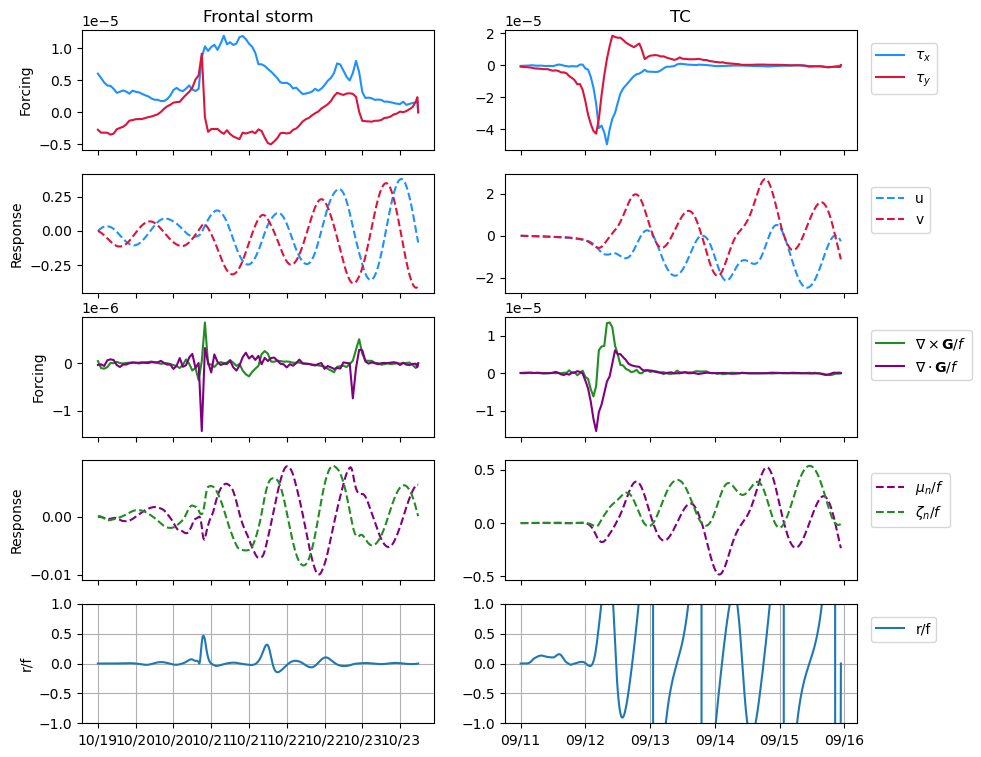

In [270]:
fig, ax = plt.subplots( nrows = 5, ncols = 2, figsize = [10, 9] )


cases = [ front_solve, tc_solve ]



for jj in range(2):
    time = cases[jj].timevec; f = cases[jj].f
    # Plot wind vectors
    ax[0, jj].plot( time, np.real( cases[jj].solutions['tau_vec'] ), color = 'dodgerblue', label = r'$\tau_x$' )
    ax[0, jj].plot( time, np.imag( cases[jj].solutions['tau_vec'] ), color = 'crimson', label = r'$\tau_y$' )
    # Plot ocean vectors
    ax[1, jj].plot( time, cases[jj].solutions['u'] , color = 'dodgerblue', label = 'u', linestyle = 'dashed' )
    ax[1, jj].plot( time, cases[jj].solutions['v'] , color = 'crimson', label = 'v', linestyle = 'dashed' )
    # Plot wind gradients
    ax[2, jj].plot( time, np.real( cases[jj].solutions['tau_grad'] ) / f, color = 'forestgreen', label = r'$\nabla \times \mathbf{G} / f$' )
    ax[2, jj].plot( time, np.imag( cases[jj].solutions['tau_grad'] ) / f, color = 'purple', label = r'$\nabla \cdot \mathbf{G} / f$' )
    
    ax[3, jj].plot( time , cases[jj].solutions['div'] /f  , color = 'purple', label = r'$\mu_n / f$', linestyle = 'dashed' )
    ax[3, jj].plot( time , cases[jj].solutions['vort'] /f , color = 'forestgreen', label = r'$\zeta_n / f$', linestyle = 'dashed' )


    ax[4,jj].plot( time, cases[jj].solutions['r'] / f, label = 'r/f' )
    ax[4,jj].set_ylim([-1,1])
    #ax[4,jj].plot( time, cases[jj].solutions['h'] )

for kk in range(5):
    
    ax[kk,1].legend( loc = 'upper left', bbox_to_anchor = [1.02, 0.95] )
    if kk < 4:
        for col in range(2):
            ax[kk, col].set_xlabel('')
            ax[kk, col].set_xticklabels([])

ax[0,0].set_title('Frontal storm')
ax[0,1].set_title('TC')

import matplotlib.dates as mdates
date_format = mdates.DateFormatter('%m/%d') 
for jj in [0,1]:
    
    ax[4,jj].xaxis.set_major_formatter(date_format)
    ax[4,jj].grid()
    ax[4,0].set_ylabel('r/f')

for jj in [0,2]:
    ax[jj,0].set_ylabel('Forcing')
    ax[jj+1,0].set_ylabel('Response')

In [271]:
fig.savefig('front_TC_slabs.pdf', dpi = 250, bbox_inches = 'tight' )

In [5]:
# Compute wind stress
def drag_coeff( wspeed ):
    Cd = 1.2e-3 * np.ones( wspeed.shape ); # ones
    faster = wspeed > 11; # meters per second
    Cd[faster] = ( 0.49 + 0.065 * wspeed.values[faster] ) * 1e-3
    fastest = wspeed > 25
    Cd[fastest] = 0.002;
    return Cd

def wstress( era_dat , surf = False):
    if surf:
        comp_vel = era_dat['u10'] + 1j*era_dat['v10']
    else:
        comp_vel = era_dat['u'].sel( pressure_level = 1000 ) + 1j * era_dat['v'].sel( pressure_level = 1000 )
    drag = drag_coeff( np.abs( comp_vel ) )
    stress = np.abs( comp_vel ) * drag * comp_vel * 1.22
    return stress

def vdiv( xr_obj ): 
    # compute vorticity and divergence from complex vector data
    divx = np.real( xr_obj ).differentiate( 'longitude' ) / ( 110e3 * np.cos( xr_obj['latitude'] / 180 * np.pi ) )
    divy = np.imag( xr_obj ).differentiate( 'latitude' ) / 110e3
    curl = np.imag( divx ) - np.real( divy )
    divv = np.real( divx ) + np.imag( divy )
    return curl, divv

get_f = lambda lat : 4 * np.pi * np.sin( lat / 180 * np.pi ) / 24/ 3600 

# Load surface datasets
tc_surf = xr.open_dataset( 'mangkhut_surf_sup.nc' ).rename({'valid_time':'time'})
front_surf = xr.open_dataset( 'front_surf_sup.nc' ).rename({'valid_time':'time'})

tc_surf['tau'] = wstress( tc_surf , surf = True )
tc_surf['taux'] = np.real( tc_surf['tau'] ); tc_surf['tauy'] = np.imag( tc_surf['tau'] )

front_surf['tau'] = wstress( front_surf , surf = True )
front_surf['taux'] = np.real( front_surf['tau'] ); front_surf['tauy'] = np.imag( front_surf['tau'] )

In [6]:
tc_surf['vort'], tc_surf['div'] = vdiv( tc_surf['tau'] )
front_surf['vort'], front_surf['div'] = vdiv( front_surf['tau'] )

In [159]:
np.mean( tc_solve.solutions['r'] )

5.723343459508241e-07

Text(0, 0.5, 'Response [10$^6$ s$^{-1}$]')

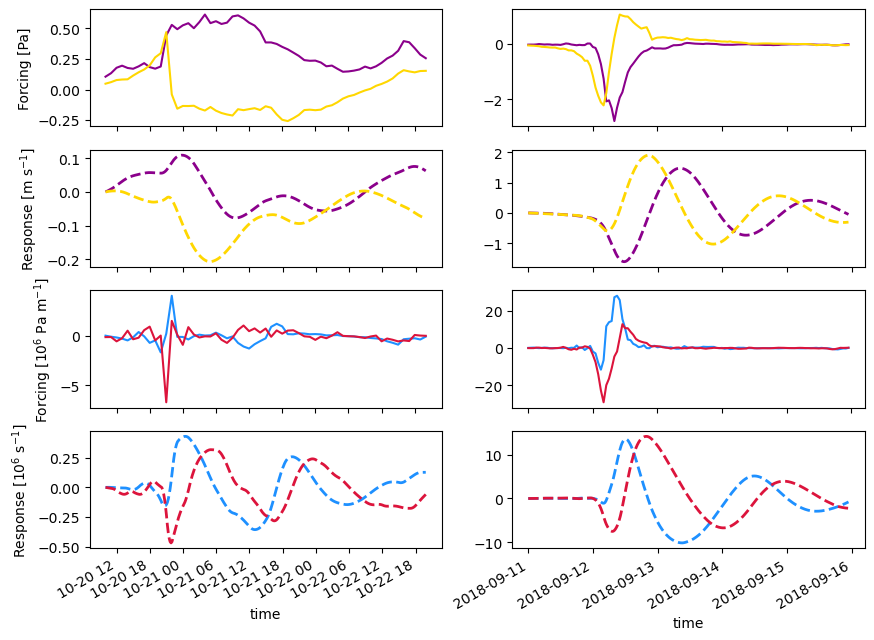

In [52]:
fig, ax = plt.subplots( figsize = [10,7], ncols = 2, nrows = 4 )

# PLOT THE FRONT
clat = 38.7; clon = 220;
ts = front_surf.sel( {'latitude':clat, 'longitude':clon}, method = 'nearest' )
ts = ts.sel( time = slice( '2021-10-20 10:00','2021-10-22 20:00' ) )

np.real( ts['tau'] ).plot( ax = ax[0,0], color = 'darkmagenta' ) 
np.imag( ts['tau'] ).plot( ax = ax[0,0], color = 'gold' )

vv, dd = solve_slab_vec( ts, get_f( clat ) )

vv.plot( ax = ax[1,0], color = 'darkmagenta' , linestyle = 'dashed', linewidth = 2 )
dd.plot( ax = ax[1,0] , color = 'gold', linestyle = 'dashed', linewidth = 2 )

# PLOT GRADIENT FORCING
(1e6 * ts['vort']).plot( ax = ax[2,0], color = 'dodgerblue' )
(1e6 * ts['div']).plot( ax = ax[2,0] , color = 'crimson' )

vv, dd = solve_slab_grad( ts, get_f( clat ) )

(1e6*vv).plot( ax = ax[3,0] , color = 'dodgerblue' , linestyle = 'dashed', linewidth = 2 )
(1e6*dd).plot( ax = ax[3,0] , color = 'crimson' , linestyle ='dashed', linewidth = 2 )

# PLOT THE TC
clat = 14.4; clon = 135; 
ts = tc_surf.sel( {'latitude':clat, 'longitude':clon}, method = 'nearest' )
ts = ts.sel( time = slice( '2018-09-11 00:00','2018-09-19 00:00' ) )

np.real( ts['tau'] ).plot( ax = ax[0,1], color = 'darkmagenta' )
np.imag( ts['tau'] ).plot( ax = ax[0,1], color = 'gold' )

vv, dd = solve_slab_vec( ts, get_f( clat ) )

vv.plot( ax = ax[1,1], color = 'darkmagenta', linestyle = 'dashed', linewidth = 2 )
dd.plot( ax = ax[1,1], color = 'gold', linestyle = 'dashed' , linewidth = 2)

(1e6 * ts['vort']).plot( ax = ax[2,1] , color = 'dodgerblue' )
(1e6 * ts['div']).plot( ax = ax[2,1], color = 'crimson' )

vv, dd = solve_slab_grad( ts, get_f( clat ) )

(1e6*vv).plot( ax = ax[3,1] , color = 'dodgerblue', linestyle = 'dashed', linewidth = 2 )
(1e6*dd).plot( ax = ax[3,1] , color = 'crimson', linestyle = 'dashed' , linewidth = 2)

for row in range(4):
    for col in range(2):
        ax[row,col].set_title('');

        if row < 3:
            ax[row,col].set_xlabel('');
            ax[row,col].set_xticklabels( [] )  
        if col == 1:
            ax[row,col].set_ylabel('')

ax[0,0].set_ylabel('Forcing [Pa]')
ax[1,0].set_ylabel('Response [m s$^{-1}$]')
ax[2,0].set_ylabel('Forcing [$10^6$ Pa m$^{-1}$]')
ax[3,0].set_ylabel('Response [10$^6$ s$^{-1}$]')


In [53]:
fig.savefig('slab_models.pdf', dpi = 250, bbox_inches = 'tight' )

In [99]:
def solve_slab_grad( tseries , f, dt = 10):
    # Use era5 timeseries to solve slab model
    # dt is in minutes
    timevec = create_timevec( tseries, dt )
    tseries = tseries.interp( time = timevec )
    vort_sol = np.zeros( timevec.shape )
    div_sol = np.zeros( timevec.shape )

    
    forc_vort = tseries['vort'] / 50 / 1024; # mixed layer scaling
    forc_div = tseries['div'] / 50 / 1024; 
    
    for jj in range( len( timevec ) - 1 ):
        
        vort_sol[jj+1] = vort_sol[jj] + 60 * dt * vort_accel( \
                          vort_sol[jj], div_sol[jj], forc_vort[jj], f = f, r = 0.2 * f , linear = False )
        div_sol[jj+1] = div_sol[jj] + 60 * dt * div_accel( \
                          vort_sol[jj], div_sol[jj], forc_div[jj], f = f, r = 0.2 * f , linear = False )

    vort_sol = xr.DataArray( data = vort_sol, dims = ('time'), coords = {'time':timevec} )
    div_sol = xr.DataArray( data = div_sol , dims = ('time'), coords = {'time':timevec} )
    return vort_sol, div_sol

def solve_slab_vec( tseries , f, dt = 10):
    # Use era5 timeseries to solve slab model
    # dt is in minutes
    timevec = create_timevec( tseries, dt )
    tseries = tseries.interp( time = timevec )
    u_sol = np.zeros( timevec.shape )
    v_sol = np.zeros( timevec.shape )

    
    forc_x = np.real( tseries['tau'] ) / 50 / 1024; # mixed layer scaling
    forc_y = np.imag( tseries['tau'] ) / 50 / 1024; 
    
    for jj in range( len( timevec ) - 1 ):
        
        u_sol[jj+1] = u_sol[jj] + 60 * dt * u_accel( \
                          u_sol[jj], v_sol[jj], forc_x[jj], f = f, r = 0.2 * f , linear = False )
        v_sol[jj+1] = v_sol[jj] + 60 * dt * v_accel( \
                          u_sol[jj], v_sol[jj], forc_y[jj], f = f, r = 0.2 * f , linear = False )

    u_sol = xr.DataArray( data = u_sol, dims = ('time'), coords = {'time':timevec} )
    v_sol = xr.DataArray( data = v_sol , dims = ('time'), coords = {'time':timevec} )
    return u_sol, v_sol


#def vort_accel( vort_now, div_now, forcing, f , r , linear = True ):
#    dvort = - f * div_now + forcing - r * vort_now
#    if linear is False:
#        dvort = dvort - vort_now * div_now
#    return dvort


#def div_accel( vort_now, div_now, forcing, f, r, linear = True ):
#    ddiv = f * vort_now + forcing - r * div_now;
#    if linear is False:
#        ddiv = ddiv + vort_now ** 2 
#    return ddiv
#
#def u_accel( u_now, v_now, forcing, f, r, linear = True ):
#    du = f * v_now + forcing - r * u_now
#    return du

#def v_accel( u_now, v_now, forcing , f, r, linear = True ):
#    dv = - f * u_now + forcing - r * v_now
#    return dv
